# F. Visualization and Cooperation with Agent

## 인공지능과 협력(?)하기

딥블루가 체스 챔피언을 이기면서 몇몇 사람들은 체스는 이제
끝났다고 말을 했습니다.
사람보다 더 잘 두는 기계가 있고, 사람이 그 녀석을 부려먹을텐데
누가 체스를 두겠냐고 생각한 것입니다.
이 생각은 반 정도는 맞는 말이었는데,
현재도 많은 사람이 체스를 두고 있어서 체스라는 게임이
망하지는 않았지만, 대회 등 사람끼리 싸워야 하는 경우에
인공지능의 수를 베끼는 골치아픈 문제가 생겼습니다.

사람끼리의 싸움에서 인공지능을 쓰는 것이 공정하냐 안 하냐를 떠나서
우리가 인공지능의 수가 최적이냐고 생각할 수 있냐는 조금 고민해볼
문제입니다.
만약에 학습된 인공지능이 신이고, 늘 신의 한 수를 둔다면 믿을만
하겠지만, 그렇지 않다면 인공지능이 판단한 것이 타당한지 검토를
할 필요가 있습니다.
그렇다면 우리는 인공지능이 생각하는 최적의 수가 무엇인지 아는 것
외에 어떤 수가 얼마나 좋다고 생각하는지 다 알아볼 필요가 있지
않을까요.

## 시각화

이전까지는 실제 게임을 실행한 뒤 기보를 보면서 인공지능의 생각을
읽은 것이 전부였습니다.
여기서는 인공지능의 policy를 시각화해서
어떻게 생각하는지 알아보고,
인공지능의 도움을 받아 사람이 수를 결정하는 인터페이스를 만들어봅니다.

## 준비작업

App.E에서 하는 것처럼 실행을 위한 모든 파일을 불러옵니다.

In [1]:
!rm -rf mock5.py
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 748.00 KiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
!rm -rf journey-to-learn-omok
!git clone https://github.com/lumiknit/journey-to-learn-omok
!mv journey-to-learn-omok/app_b_last.weight app_e.weight

Cloning into 'journey-to-learn-omok'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 260 (delta 113), reused 125 (delta 75), pack-reused 71
Receiving objects: 100% (260/260), 21.66 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [3]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

Device: cuda


In [4]:
H, W = 15, 15

In [5]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
    
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      Flatten(),
      nn.LogSoftmax(dim=-1))

  def forward(self, x): return self.seq(x)

In [6]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)

# agent: (Mock5 -> distr) -> (Mock5 -> (row, col))
# 입력은 Mock5를 입력받아서 numpy.array로 각 action을 실행할 확률 분포를 반환
# 반환값은 함수로, Mock5를 입력받아서 다음에 돌을 둘 행, 열을 정수로 반환
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

# policy_model: Policy -> (Mock5 -> distr)
# Policy 클래스로 된 network를 입력받아
# Mock5를 받으면 각 행동을 할 확률분포를 numpy.array로 반환하는 함수
def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

# 실제로 Policy 클래스로 행동을 확인하고 싶다면
# agent_policy(network)로도 충분합니다.
def agent_policy(net): return agent(policy_model(net))

In [7]:
# 늘 샌드백으로 쓰였던 agent_mixed
def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

In [8]:
def test_agents(num_game, agent1, agent2, p_msg=True):
  agents = [agent1, agent2]
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agents[i % 2], agents[(i + 1) % 2], random_first=False,
      print_intermediate_state=False, print_messages=False)
    if result != 0 and i % 2 == 1: result = 3 - result
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  if p_msg:
    print("-- Test Result --")
    print("* Agent1 = {} \n* Agent2 = {}".format(fn_name(agent1), fn_name(agent2)))
    print("Total : {:5d}".format(num_game))
    print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
    print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))
  return (w1 + (num_game - w1 - w2) * 0.5) / num_game

In [9]:
WEIGHT_FILE = 'app_e.weight'

def load_hof_file(filename):
  policies = []
  hof = torch.load(filename)
  for sl in hof['slots']:
    pi = Policy().to(device)
    pi.load_state_dict(sl['dict'])
    policies.append(pi)
  return policies

policies = load_hof_file(WEIGHT_FILE)

## Policy 확률분포 시각화하기

기존 Mock5.py의 `.plot` 메소드에
policy를 색깔로 표현합니다.

다만, 그냥 policy를 사용하게 되면 대부분의 수는 확률이 낮아
잘 보이지 않으므로, temperture를 조절하도록 합니다.

In [104]:
def plot_game_prepare(game, title, dpi):
  plt.figure(
      figsize=(game.width, game.height),
      dpi=dpi)
  plt.title("{} (Turn {}; {}p; {} stone)".format(
      title,
      1 + len(game.history),
      game.player,
      [None, "black", "white"][game.player]), fontsize=20)
  plt.axis('off')

def plot_game_grid(game):
  ax = lambda x: x if x < 10 else chr(ord('A') + x - 10)
  for i in range(1, game.height + 1):
    plt.plot([1, game.width], [i, i], zorder=1.0, c = '0.5')
    plt.text(0, i, ax(game.height - i), zorder=3.0, ha='center', va='center',
             fontdict={'weight': 'bold', 'size': 20, 'color': '0.5'})
  for i in range(1, game.width + 1):
    plt.plot([i, i], [1, game.height], zorder=1.0, c = '0.5')
    plt.text(i, 0, ax(i - 1), zorder=3.0, ha='center', va='center',
             fontdict={'weight': 'bold', 'size': 20, 'color': '0.5'})
    
def plot_game_stones(game, num_number):
  fonts = [
    {'weight': 'bold', 'size': 20, 'color': 'white'},
    {'weight': 'bold', 'size': 20, 'color': 'black'},
  ]
  colors = ['black', 'white']
  n_from = max(0, len(game.history) - num_number)
  for i, p in enumerate(game.history):
    y = game.height - p // game.width
    x = 1 + p % game.width
    plt.gcf().gca().add_patch(
        plt.Circle((x, y), 0.46, zorder=2.0, color=colors[i % 2], fill=True))
    plt.gcf().gca().add_patch(
        plt.Circle((x, y), 0.46, zorder=2.0, color=colors[(i + 1) % 2], fill=False))
    if i - n_from >= 0:
      plt.text(
          x, y, str(i - n_from + 1), zorder=3.0,
          ha='center', va='center', fontdict=fonts[i % 2])

def plot_game(game, policy=None, title="", num_number=65536, temperture=0.3, dpi=36):
  plot_game_prepare(game, title, dpi)
  # Draw Policy
  if policy is not None:
    p = policy.reshape(game.height, game.width)
    p = p ** temperture
    plt.imshow(p,
              cmap='coolwarm',
              interpolation='hermite',
              extent=(0.5, 0.5 + game.width, 0.5, 0.5 + game.height))
  # Draw board
  plot_game_grid(game)
  plot_game_stones(game, num_number)

이를 이용하면 다음과 같은 이미지를 볼 수 있습니다.

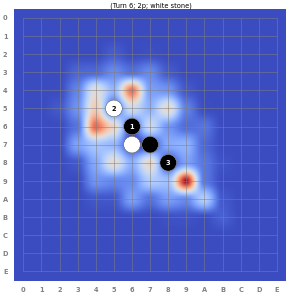

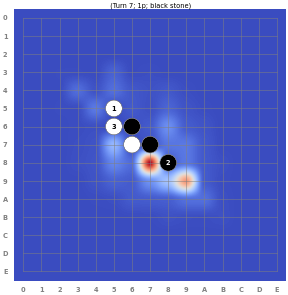

In [73]:
m = Mock5(H, W)
m.place_stone(H // 2, W // 2)
m.place_stone(H // 2, W // 2 - 1)
m.place_stone(H // 2 - 1, W // 2 - 1)
m.place_stone(H // 2 - 2, W // 2 - 2)
m.place_stone(H // 2 + 1, W // 2 + 1)
p = policy_model(policies[1])(m)
plot_game(m, p, num_number=3, dpi=24)
m.place_stone(H // 2 - 1, W // 2 - 2)
p = policy_model(policies[1])(m)
plot_game(m, p, num_number=3, dpi=24)

이미지에서 파란색->흰색->빨간색으로 변할수록 policy가
높아지며, 빨갛게 나오는 부분들이 사실상 policy에게
선택될 가능성이 있는 수입니다.

In [53]:
def plot_all(game, policy_fn=None, title="", num_number=65536, temperture=0.3, dpi=24):
  m = Mock5(game.height, game.width)
  plot_game(m, policy_fn(m), title, num_number, temperture, dpi)
  plt.show()
  plt.close()
  for idx in game.history:
    m.place_stone_at_index(idx)
    plot_game(m, policy_fn(m), title, num_number, temperture, dpi)
    plt.show()
    plt.close()

 [ Turn  26 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . X . . . .
3 | . . . . . . . . O O X . O . .
4 | . . . . . . . O X X X X O . .
5 | . . . . . . . X O . X . . . .
6 | . . . . . . X O . X X X O . .
7 | . . . . . O O O X . O . . . .
8 | . . . . . . . O . . . . . . .
9 | . . . . . . . . . . . . . . .
A | . . . . . . . . . . . . . . .
B | . . . . . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
2p (stochastic(model(7fdaafe74c50))) win!


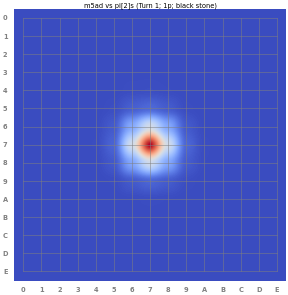

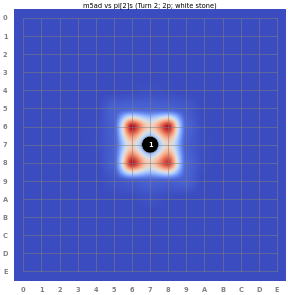

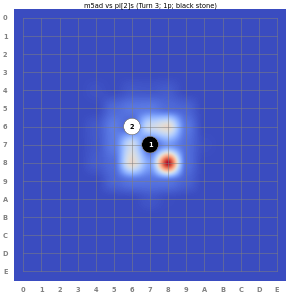

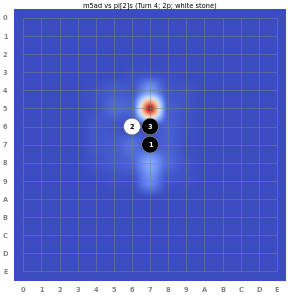

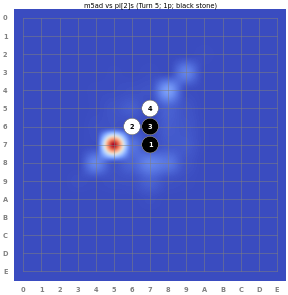

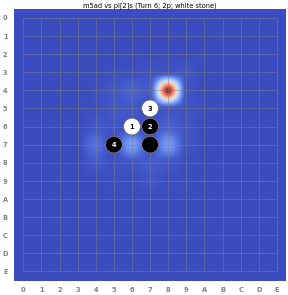

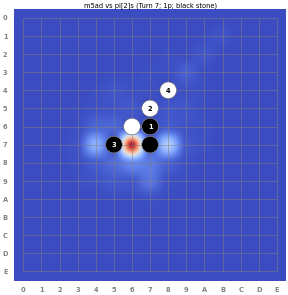

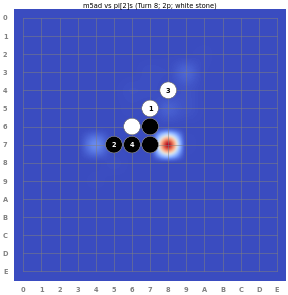

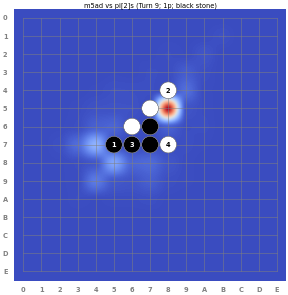

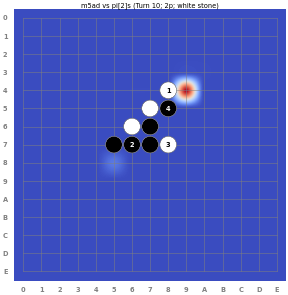

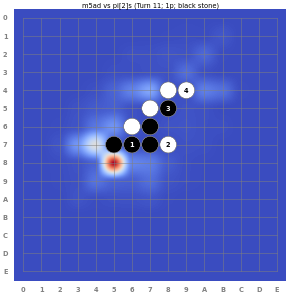

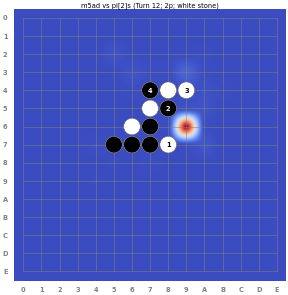

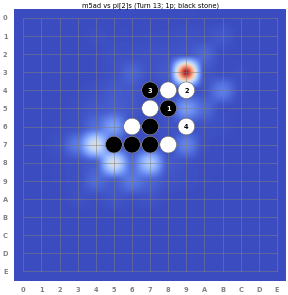

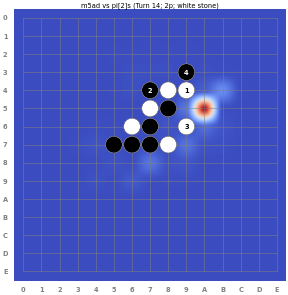

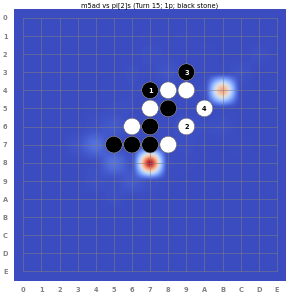

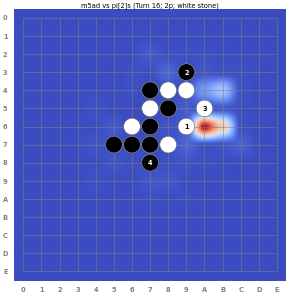

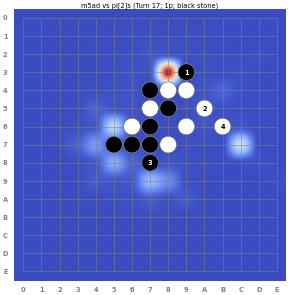

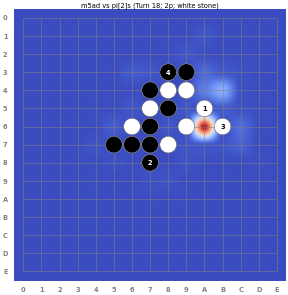

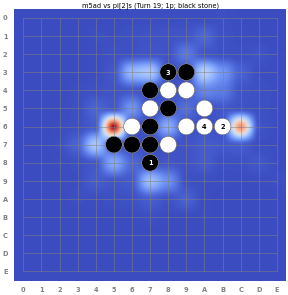

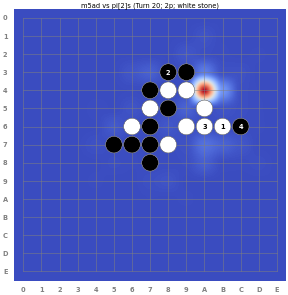

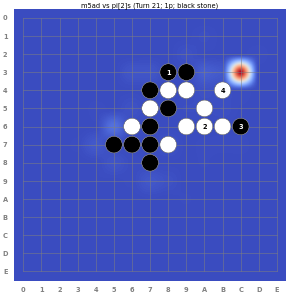

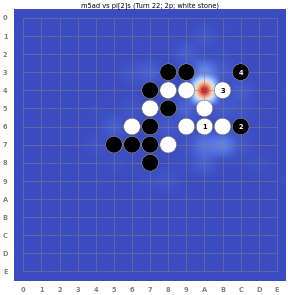

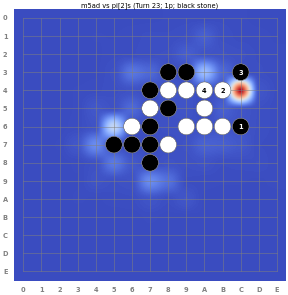

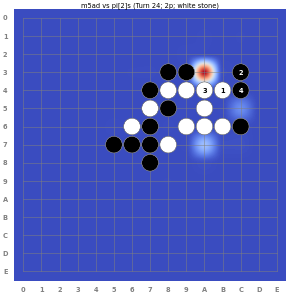

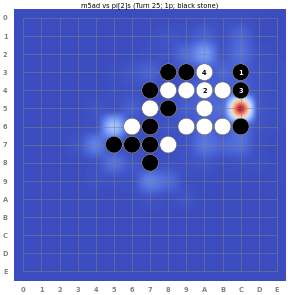

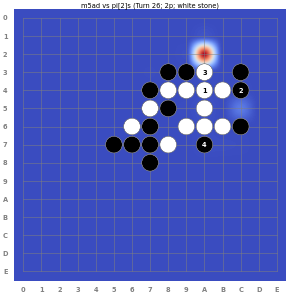

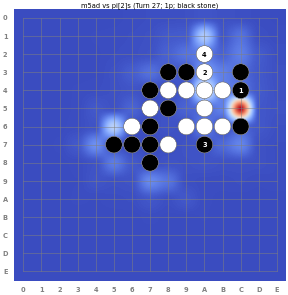

In [74]:
m = Mock5(H, W)
m.play(m5ad.agent, agent_policy(policies[2]),
       random_first=False, print_intermediate_state=False)
plot_all(m, policy_fn=policy_model(policies[2]), title="m5ad vs pi[2]s", num_number=4)

위의 `plot_all`로 각 기보마다 학습된 모델이 생각하는 것을 보면
몇가지 재밌는 사실을 알 수 있습니다.

- 알고리즘이 두는 수를 비교적 따릅니다. 알고리즘 차례일 때
예측한 policy와 알고리즘 수를 비교해보면, 알고리즘의 수와
같이 둘 확률이 전반적으로 낮지 않은 것을 볼 수 있습니다.
- 제일 처음 아무것도 없는 상태에서 중앙을 정확하게 찾는 것을
볼 수 있습니다.
- 모델이 가장 좋아하는 시작은
중앙, 간접주형(대각선 둠), 사월(반대 대각선에 둠) 입니다.
- 알고리즘을 이기기 위해서 변한 것인지, 스스로 대국하면서 바뀐
것인지 모르겠지만, 3-4 등에 매우 민감하게 반응합니다.
- 마땅한 수가 없거나, 게임이 사실상 끝난 경우에 확률이 분산되는
것을 볼 수 있습니다.
- 이미 돌이 존재하는 위치가 높은 확률을 갖는 경우는 사실상
별로 없습니다. 초반에는 돌이 있는 위치는 확률이 사실상 0임을
볼 수 있고, 게임이 진행되면서 배치가 얽히다보면 돌이 있는 곳도
확률이 조금 올라가는 것을 볼 수 있습니다.

## 두 Policy 비교하기

2개의 policy가 있을 때 확률이 얼마나 다른지 시각화해봅니다.

In [89]:
def plot_diff_game(game, p1, p2, title="", num_number=65536, dpi=36):
  plot_game_prepare(game, title, dpi)
  # Draw Policy
  p1 = p1.reshape(game.height, game.width)
  p2 = p2.reshape(game.height, game.width)
  p = ((p1 - p2) * 0.5 + 0.5)
  plt.imshow(p,
             cmap='seismic',
             interpolation='hermite',
             vmin=0.0, vmax=1.0,
             extent=(0.5, 0.5 + game.width, 0.5, 0.5 + game.height))
  # Draw board
  plot_game_grid(game)
  plot_game_stones(game, num_number)

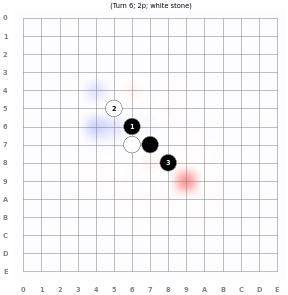

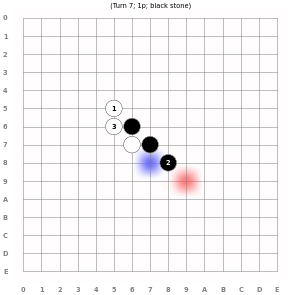

In [90]:
m = Mock5(H, W)
m.place_stone(H // 2, W // 2)
m.place_stone(H // 2, W // 2 - 1)
m.place_stone(H // 2 - 1, W // 2 - 1)
m.place_stone(H // 2 - 2, W // 2 - 2)
m.place_stone(H // 2 + 1, W // 2 + 1)
p1 = policy_model(policies[1])(m)
p2 = policy_model(policies[2])(m)
plot_diff_game(m, p1, p2, num_number=3, dpi=24)
m.place_stone(H // 2 - 1, W // 2 - 2)
p1 = policy_model(policies[1])(m)
p2 = policy_model(policies[2])(m)
plot_diff_game(m, p1, p2, num_number=3, dpi=24)

여기서는 흰색은 두 agent가 모두 비슷하게 추정하는 지점이며,
빨간색일 수록 첫번째 policy가 더 선호하는 위치, 파란색일수록
두번째 policy가 더 선호하는 수입니다.
보면 생각보다 두 policy가 서로 생각하는게 다른 것을 볼 수도
있습니다.

## 여러 policy 동시에 시각화하기

여러 agent의 확률을 동시에 확인해봅니다.

In [95]:
def plot3_game(game, p1, p2, p3, title="", num_number=65536, temperture=0.3, dpi=36):
  plot_game_prepare(game, title, dpi)
  # Draw Policy
  p1 = p1.reshape(game.height, game.width) ** temperture
  p2 = p2.reshape(game.height, game.width) ** temperture
  p3 = p3.reshape(game.height, game.width) ** temperture
  p = np.stack((p1, p2, p3), axis=-1)
  plt.imshow(p,
             interpolation='hermite',
             extent=(0.5, 0.5 + game.width, 0.5, 0.5 + game.height))
  # Draw board
  plot_game_grid(game)
  plot_game_stones(game, num_number)

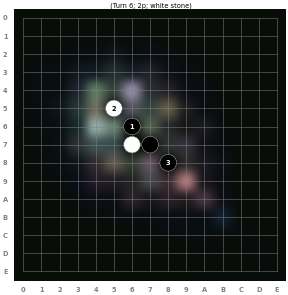

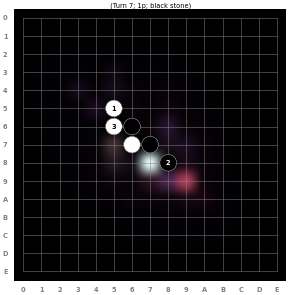

In [96]:
m = Mock5(H, W)
m.place_stone(H // 2, W // 2)
m.place_stone(H // 2, W // 2 - 1)
m.place_stone(H // 2 - 1, W // 2 - 1)
m.place_stone(H // 2 - 2, W // 2 - 2)
m.place_stone(H // 2 + 1, W // 2 + 1)
p1 = policy_model(policies[1])(m)
p2 = policy_model(policies[2])(m)
p3 = policy_model(policies[3])(m)
plot3_game(m, p1, p2, p3, num_number=3, dpi=24)
m.place_stone(H // 2 - 1, W // 2 - 2)
p1 = policy_model(policies[1])(m)
p2 = policy_model(policies[2])(m)
p3 = policy_model(policies[3])(m)
plot3_game(m, p1, p2, p3, num_number=3, dpi=24)

여기서는 red, green, blue 채널 각각이 policy 1, 2, 3의
확률을 나타냅니다. 즉, 무채색에 가까울수록 모든 policy가
비슷하게 고평가하는 수이며, 각 채널의 밝기가 높을수록 해당
policy가 고평가하는 수입니다.

위 이미지에서 맨 아래를 보면 흑2 우하단 수는 policy1이 주로
선호하지만, 다른 policy는 선호하지 않고,
흑2 왼쪽 수를 대부분 policy가 선호하는 것을 볼 수 있습니다.

In [99]:
def plot3_all(game, p1_fn, p2_fn, p3_fn, title="", num_number=65536, temperture=0.3, dpi=24):
  m = Mock5(game.height, game.width)
  plot3_game(m, p1_fn(m), p2_fn(m), p3_fn(m), title, num_number, temperture, dpi)
  plt.show()
  plt.close()
  for idx in game.history:
    m.place_stone_at_index(idx)
    plot3_game(m, p1_fn(m), p2_fn(m), p3_fn(m), title, num_number, temperture, dpi)
    plt.show()
    plt.close()

 [ Turn  18 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . .
6 | . . . . . . . O . . . . . . .
7 | . . . . . O O O X O . . . . .
8 | . . . . . . X O . X . . . . .
9 | . . . . . . . X O X . . . . .
A | . . . . . . . O X X . . . . .
B | . . . . . . . . . X . . . . .
C | . . . . . . . . . X O . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
2p (stochastic(model(7fdaafe74c50))) win!


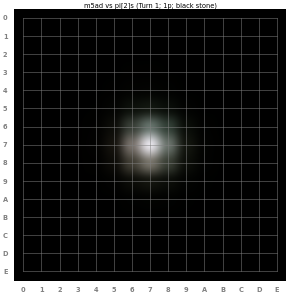

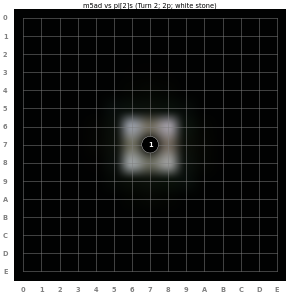

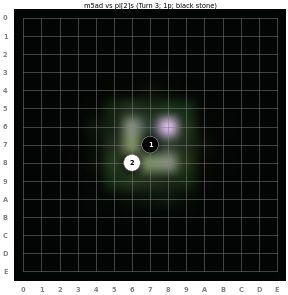

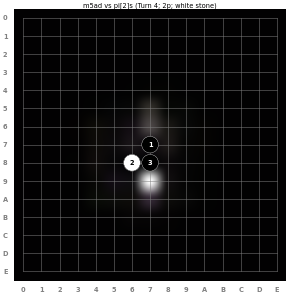

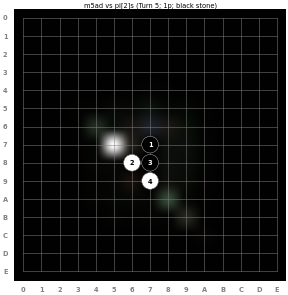

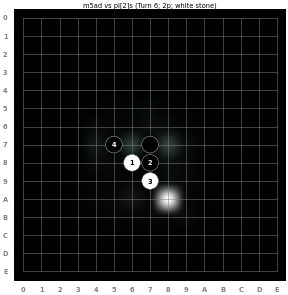

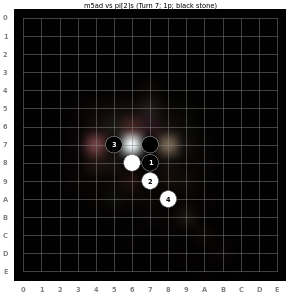

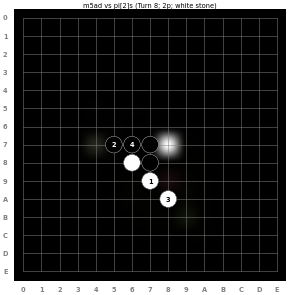

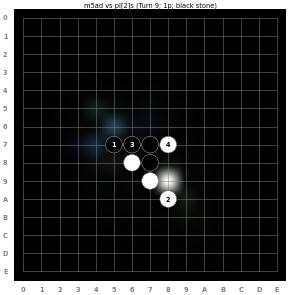

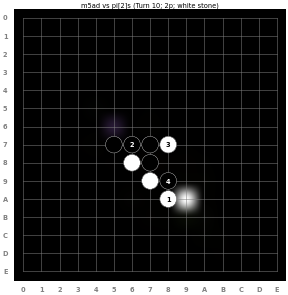

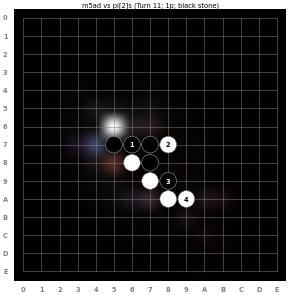

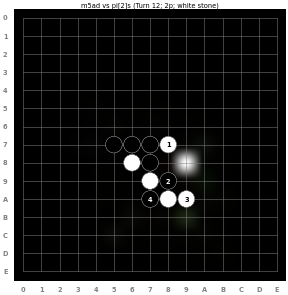

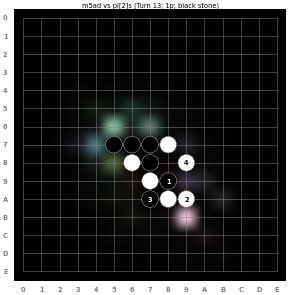

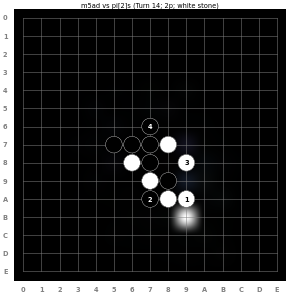

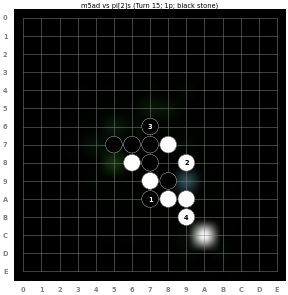

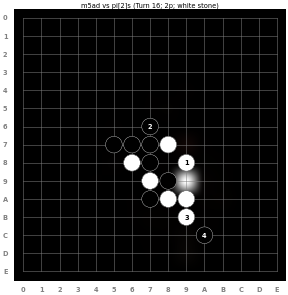

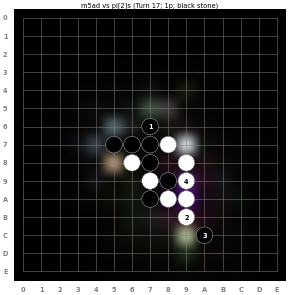

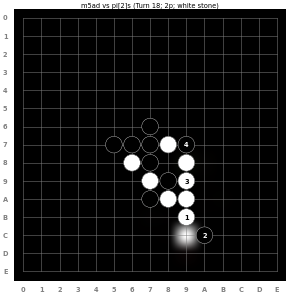

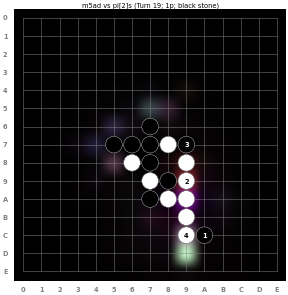

In [101]:
m = Mock5(H, W)
m.play(m5ad.agent, agent_policy(policies[2]),
       random_first=False, print_intermediate_state=False)
pm1 = policy_model(policies[0])
pm2 = policy_model(policies[1])
pm3 = policy_model(policies[2])
plot3_all(m, pm1, pm2, pm3, title="m5ad vs pi[2]s", num_number=4)

위와 같이 기보를 출력해보면, 특정 policy는
전반적으로 색이 많이 보이고 (= 많이 분산되어 있음),
특정 policy는 잘 안 보이는 것 (= 특정 수에 집중되어 있음)
을 확인할 수 있습니다.

그렇지만 중요한 수에 대한 판단은 대부분 일치하여 하얗게 칠해지는
것이 포인트입니다.

## 힌트 받아서 게임해보기

여기서는 학습된 agent의 생각을 보고 사람이 직접 판단하여
수를 두는 식으로 게임을 진행합니다.

In [111]:
def _digit_to_int(s, offset=0):
  v = ord(s[offset])
  if 48 <= v and v < 48 + 10: return v - 48
  elif 65 <= v and v < 65 + 26: return v - 65 + 10
  elif 97 <= v and v < 97 + 26: return v - 97 + 10
  else: return None

def play_with_hint(opponent, policies, temperture=0.3, dpi=24):
  game = Mock5(H, W)
  t = np.random.randint(2)
  title = ("Human w/ Model v.s. {}" if t == 0 else "Human w/ Model v.s. {}").format(opponent.name)
  print(title)
  while 1:
    if game.player == 1 + t:
      if len(policies) == 1:
        plot_game(game, policies[0](game),
                  title=title, num_number=4, temperture=temperture, dpi=dpi)
      elif len(policies) <= 3:
        plot3_game(game, policies[0](game), policies[1](game), policies[-1](game),
                  title=title, num_number=4, temperture=temperture, dpi=dpi)
      else:
        raise "TOO MANY POLICIES!"
      plt.show()
      plt.close()
      print("Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`")
      while 1:
        v = input("> ").strip()
        if v == 'undo':
          r, c = False, False
          game.undo()
          game.undo()
          break
        elif len(v) != 2: print("Please type row & column in ``2 characters``")
        else:
          r, c = _digit_to_int(v[0]), _digit_to_int(v[1])
          if (r is None) or (c is None): print("Wrong row/column")
          else: break
    else:
      r, c = opponent(game)
    if r is not False:
      if not game.place_stone(r, c):
        print("Player {} place a stone on stone!".format(game.player))
        w = 3 - game.player
        break
      w = game.check_win()
      if w is not None: break
  plot_game(game, None, title=title, dpi=dpi)
  if w != None:
    if w == 0: print("Draw!")
    elif w == 1 + t: print("You win!")
    else: print("Op win!")
  return w

Human w/ Model v.s. agent-analysis-defensive


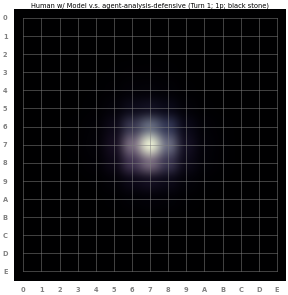

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 77


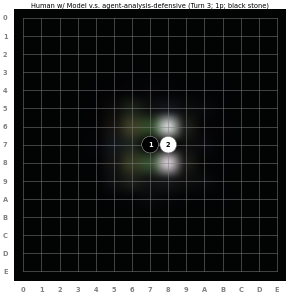

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 67


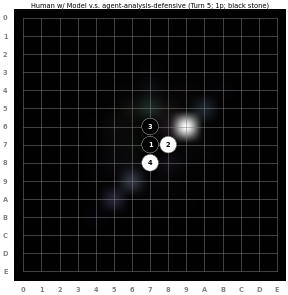

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 69


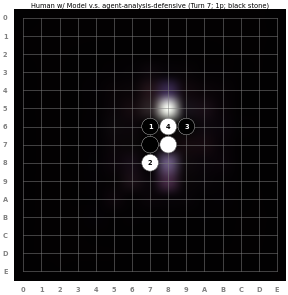

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 58


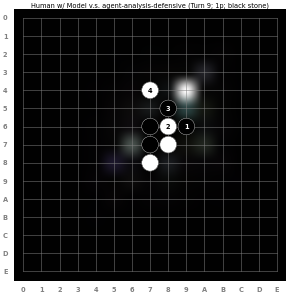

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 49


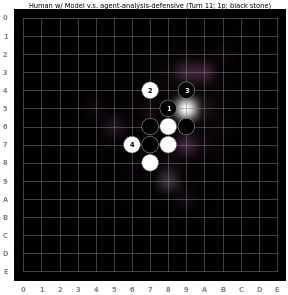

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 59


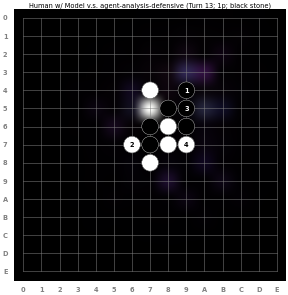

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 39


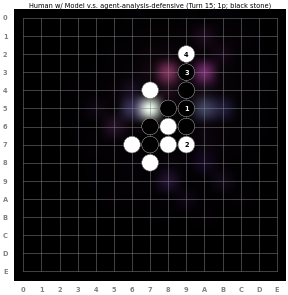

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 57


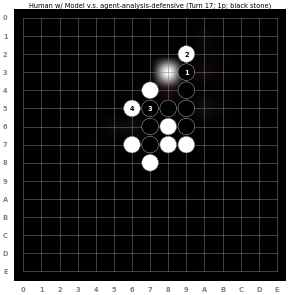

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 38


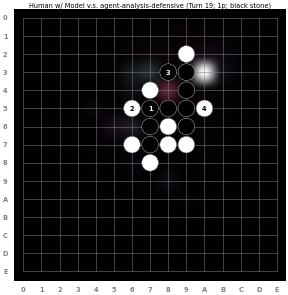

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 3a


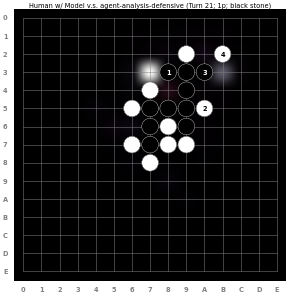

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 37


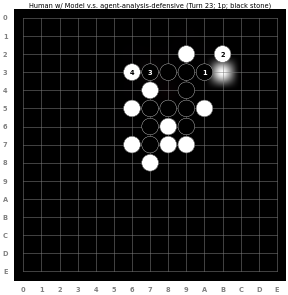

Your turn! Please enter row & column (e.g. `3A`, `77`, `80`) or `undo`
> 3b
You win!


1

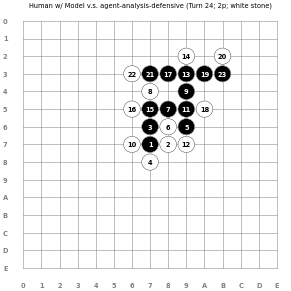

In [114]:
guide = [policy_model(policies[0]), policy_model(policies[2]), policy_model(policies[-1])]
play_with_hint(m5ad.agent, guide)